In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical  # for one-hot encoding

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []

In [ ]:
# dictionary of label encoding for each image
class_label_encoding = {
    'SPOILED': 0,
    'HALF-FRESH': 1,
    'FRESH': 2
}

In [ ]:
# Function to load images and labels
def load_images_and_labels(dataset_dir, img_size=(128, 128)):
    images = []
    labels = []

    for file_name in os.listdir(dataset_dir):
        if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue  # Ignore non-image files

        # Extract class name based on the file name
        if file_name.startswith("SPOILED"):
            class_name = "SPOILED"
        elif file_name.startswith("FRESH"):
            class_name = "FRESH"
        elif file_name.startswith("HALF-FRESH"):
            class_name = "HALF-FRESH"
        else:
            print(f"Skipping file with unexpected class name: {file_name}")
            continue

        # Load and process the image
        img_path = os.path.join(dataset_dir, file_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0   # Normalize the image

        images.append(img_array)

        # Use class_name for labeling
        labels.append(class_label_encoding[class_name])

    return np.array(images), np.array(labels, dtype=int)

# Define paths for training and testing
train_path = '/content/drive/MyDrive/Meat Freshness.v1-new-dataset.multiclass/train'
test_path = '/content/drive/MyDrive/Meat Freshness.v1-new-dataset.multiclass/valid'

# Load training images and labels
train_images, train_labels = load_images_and_labels(train_path, img_size=(128, 128))

# Load testing images and labels
test_images, test_labels = load_images_and_labels(test_path, img_size=(128, 128))

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)

# Print shapes of the loaded images
print("Training Images Shape:", train_images.shape)
print("Training Labels Shape:", train_labels.shape)
print("Testing Images Shape:", test_images.shape)
print("Testing Labels Shape:", test_labels.shape)

train_image_count = sum(1 for file_name in os.listdir(train_path) if file_name.lower().endswith(('.png', '.jpg', '.jpeg')))
test_image_count = sum(1 for file_name in os.listdir(test_path) if file_name.lower().endswith(('.png', '.jpg', '.jpeg')))

print(f"Total images in train folder: {train_image_count}")
print(f"Total images in test folder: {test_image_count}")

Training Images Shape: (1815, 128, 128, 3)
Training Labels Shape: (1815, 3)
Testing Images Shape: (451, 128, 128, 3)
Testing Labels Shape: (451, 3)
Total images in train folder: 1815
Total images in test folder: 451


In [ ]:
# Model architecture
model = models.Sequential()

# Convolutional Layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

# Fully Connected Layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))  # 3 classes for one-hot encoded labels

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 59, 59, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 445568)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      57,032,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,126,467 (217.92 MB)

 Trainable params: 57,126,467 (217.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_images)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Fit the model
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                    validation_data=(test_images, test_labels),
                    epochs=50,
                    callbacks=[early_stopping])

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 328ms/step - accuracy: 0.3815 - loss: 1.2288 - val_accuracy: 0.5854 - val_loss: 1.0307
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.5031 - loss: 0.9984 - val_accuracy: 0.6519 - val_loss: 0.8383
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.5591 - loss: 0.8937 - val_accuracy: 0.6452 - val_loss: 0.7234
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.6111 - loss: 0.7686 - val_accuracy: 0.6851 - val_loss: 0.6755
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6747 - loss: 0.7128 - val_accuracy: 0.6319 - val_loss: 0.7528
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.7035 - loss: 0.6792 - val_accuracy: 0.6918 - val_loss: 0.6502
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7183 - loss: 0.6399 - val_accuracy: 0.7007 - val_loss: 0.6688
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.6787 - loss: 0.7086 - val_accura

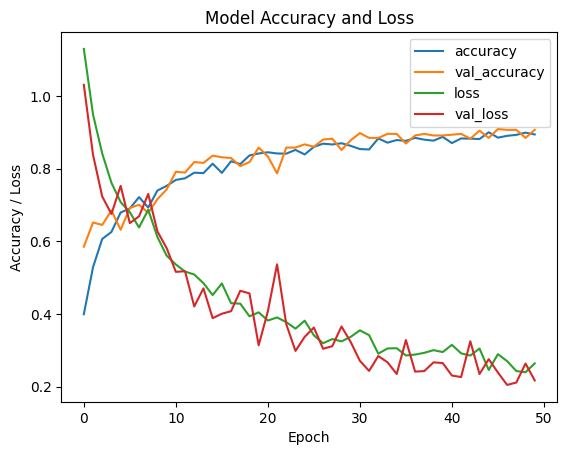

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.title('Model Accuracy and Loss')
plt.legend()
plt.show()

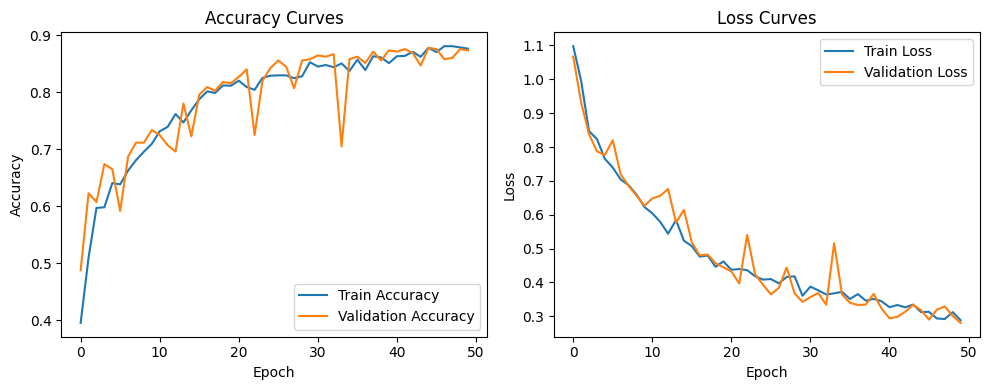

In [ ]:
plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation on Validation Data
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 87.36%
Test Loss: 0.2806


In [ ]:
# PPredictions on the test labels
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Accuracy: 87.36%
Precision: 87.36%
Recall: 87.36%
F1 Score: 87.32%


In [ ]:
# Generate Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_label_encoding.keys()))

Classification Report:
              precision    recall  f1-score   support

     SPOILED       0.96      0.99      0.97       114
  HALF-FRESH       0.81      0.84      0.82       159
       FRESH       0.88      0.83      0.85       178

    accuracy                           0.87       451
   macro avg       0.88      0.89      0.88       451
weighted avg       0.87      0.87      0.87       451



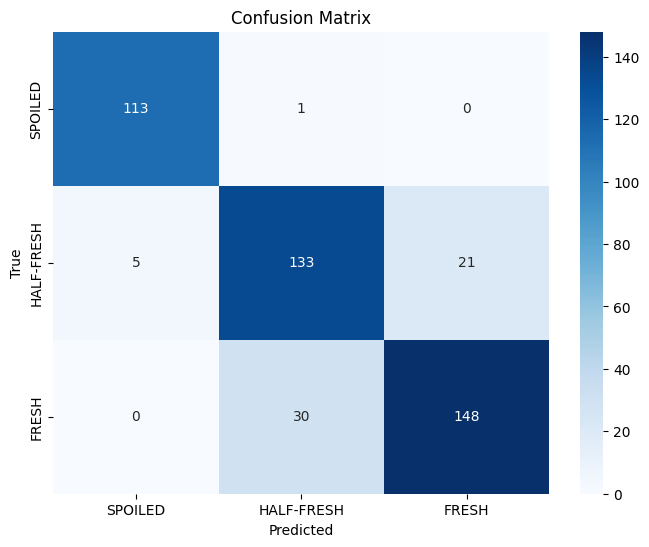

In [ ]:
# Visualization with confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_label_encoding.keys(), yticklabels=class_label_encoding.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()